<a href="https://colab.research.google.com/github/gvtsch/Udemy_TensorFlow_Certificate/blob/main/06_transfer_learning_with_TensorFlow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Our baseline to beat 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jun 27 20:21:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8    11W /  N/A |    654MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper funtions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
import os

if not os.path.exists("helper_functions.py"):
  # !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
  !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_notification notebook.

In [6]:
if not os.path.exists("101_food_classes_10_percent/"):
  # !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  unzip_data("101_food_classes_10_percent.zip")


Saved under 101_food_classes_10_percent.zip

Saved under 101_food_classes_10_percent (1).zip

Saved under 101_food_classes_10_percent (2).zip


In [7]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [8]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [13]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # Rescale inputs to 0 between, if not already rescaled like EfficientNet
], name="data_augmentation")

In [15]:
# Setup the base_model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (this only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
# Get summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [21]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [22]:
# Fit it for 5 epochs
initial_epochs = 5

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)), # validate on 15%
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="101_food_classes_10_percent"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/101_food_classes_10_percent/20220627-211122


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
237/237 [==============================] - 129s 466ms/step - loss: 3.4657 - accuracy: 0.2508 - val_loss: 2.5552 - val_accuracy: 0.4388
Epoch 2/5
237/237 [==============================] - 76s 322ms/step - loss: 2.3423 - accuracy: 0.4652 - val_loss: 2.1291 - val_accuracy: 0.4992
Epoch 3/5
237/237 [==============================] - 69s 291ms/step - loss: 1.9748 - accuracy: 0.5279 - val_loss: 1.9804 - val_accuracy: 0.5106
Epoch 4/5
237/237 [==============================] - 63s 266ms/step - loss: 1.7567 - accuracy: 0.5772 - val_loss: 1.8951 - val_accuracy: 0.5172
Epoch 5/5
237/237 [==============================] - 60s 252ms/step - loss: 1.5960 - accuracy: 0.6135 - val_loss: 1.8856 - val_accuracy: 0.5106


In [23]:
# Evaluate on the whole test dataset
model.evaluate(test_data)

790/790 [==============================] - 74s 94ms/step - loss: 1.7082 - accuracy: 0.5542


[1.7082455158233643, 0.5542178153991699]

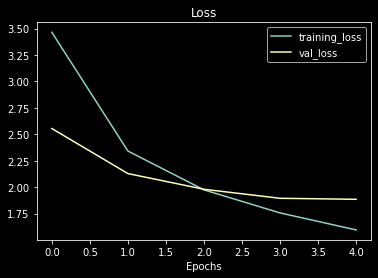

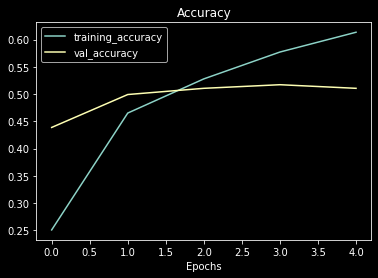

In [24]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: Ideally, the two curves should be pretty similar to each other, if not ...